# District Heating Network Simulation with Graphical Neural Networks
by Xiyun Fu

We will walk through the following steps:

1. Installation and Setup
2. Creating a dataloader
3. Building the Model
4. Creating train and evaluation functions
5. Train the model
6. Test the model

## Installation and setup

In [1]:
import torch
print('Torch', torch.__version__, 'CUDA', torch.version.cuda)
print('Device:', torch.device('cuda:0'))
if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")
print(device)

Torch 2.1.0+cu121 CUDA 12.1
Device: cuda:0
cuda


Install PyTorch, PyG, and other necessary python libraries

In [2]:
!pip install torchvision torchaudio
!pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 7.4 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd
from google.colab import files
import networkx as nx
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import StandardScaler


Mount google

In [6]:
from google.colab import drive
drive.mount('/content/drive')
# drive.mount('/content/drive', force_remount=True)
# %cd '/content/'
# !git clone git@github.com:xiyunfu/DHN-simulation.git
# %cd DHN-simulation/data

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Create graph structure

In [23]:
LOOP = True
if LOOP:
  general_info_path = "/content/drive/My Drive/Colab Notebooks/general_info-loop"
else:
  general_info_path = "/content/drive/My Drive/Colab Notebooks/general_info"

substations = pd.read_csv(os.path.join(general_info_path, 'substations.csv'))
heating_stations = pd.read_csv(os.path.join(general_info_path,'heating_stations.csv'))
network_points = pd.read_csv(os.path.join(general_info_path,'network_points.csv'))
pipes = pd.read_csv(os.path.join(general_info_path,'pipes.csv'))

pipes['dn_in'], pipes['dn_out'] = zip(*pipes['dn'].str.split("/"))
print(f"network point number: {len(network_points)} \n pipes number: {len(pipes)}")

network point number: 1150 
 pipes number: 1150


In [8]:
# pipes connect with X.- nodes
pipes_x = pipes.loc[(pipes['startpoint'].str.startswith('X')) | (pipes['endpoint'].str.startswith('X'))]
# all the X.- node and two start and end nodes connect with them, in both supply and return network
nodes_x = pd.concat([pipes_x['startpoint'], pipes_x['endpoint']]).unique().tolist()
network_points_x = network_points.loc[network_points['npid'].isin(nodes_x)]

supply_nodes_x = ['A.75.4']  # the start point of the loop in supply network
return_nodes_x = ['R.75.4'] # the end point of the loop in return network

while True:
    supply_node = pipes_x.loc[pipes_x['startpoint'].str.startswith(supply_nodes_x[-1])]['endpoint']
    return_node = pipes_x.loc[pipes_x['endpoint'].str.startswith(return_nodes_x[-1])]['startpoint']

    if not supply_node.empty:
        supply_nodes_x.append(supply_node.iloc[0])
    else:
        break
    if not return_node.empty:
      return_nodes_x.append(return_node.iloc[0])
    else:
      break

In [9]:
print(supply_nodes_x, '\n', return_nodes_x)
# create dictionary x2ar to convert the X prefix to A/R
x2ar = {}
for a, r in zip(supply_nodes_x, return_nodes_x):
  x2ar[a] = a.replace("X", "A")
  if r.split('.')[0] == 'X':
    x2ar[r] = a.replace("X", "R")
  else:
    x2ar[r] = r

xlist = list(x2ar.keys())
xvaluelist = list(x2ar.values())

['A.75.4', 'X.1031', 'X.1029', 'X.1026', 'X.1028', 'X.1024', 'X.1022', 'X.1020', 'X.1018', 'X.1016', 'X.1012', 'X.1011', 'A.26'] 
 ['R.75.4', 'X.1032', 'X.1030', 'X.1025', 'X.1027', 'X.1023', 'X.1021', 'X.1019', 'X.1017', 'X.1015', 'X.1010', 'X.1009', 'R.26']


In [10]:
import geopandas as gpd
from shapely import wkb

network_points['geometry'] = network_points['geom'].apply(lambda x: wkb.loads(bytes.fromhex(x)) if x else None)
gdf = gpd.GeoDataFrame(network_points, geometry='geometry')
gdf_ep = gdf.explode(index_parts=True)
gdf_ep["X"] = gdf_ep.geometry.x
gdf_ep["Y"] = gdf_ep.geometry.y
network_points = pd.DataFrame(gdf_ep).reset_index(drop=True)

# convert X to A/R in pipes and network_points
pipes['startpoint'] = [x2ar.get(x, x) for x in pipes['startpoint']]
pipes['endpoint'] = [x2ar.get(x, x) for x in pipes['endpoint']]
network_points['npid'] = [x2ar.get(x, x) for x in network_points['npid']]
# all the points and pipes in supply network
network_points_supply = network_points[network_points['npid'].apply(lambda x: x.startswith("A")) ]
                                      #  network_points['npid'].isin(supply_nodes_x)]

network_points_return = network_points[network_points['npid'].apply(lambda x: x.startswith("R"))]
                                      #  network_points['npid'].isin(return_nodes_x)]

pipes_supply = pipes[pipes['startpoint'].apply(lambda x: x.startswith("A")) ] #| pipes['startpoint'].isin(supply_nodes_x)]
print(network_points_supply.shape, network_points_supply.shape, pipes_supply.shape)

(575, 10) (575, 10) (575, 14)


Plot the network structure

In [11]:
G = nx.DiGraph()

for i, r in network_points_supply.iterrows():
    G.add_node(r['npid'])

for index, row in pipes_supply.iterrows():
    G.add_edge(row['startpoint'], row['endpoint'], length=row['length'], dn_in=row['dn_in'])

pos = {row['npid']: (float(row['X']), float(row['Y'])) for _, row in network_points_supply.iterrows()}
# print(pos)
count = 0
node_colors = []
for node in G.nodes():
    if node in xvaluelist:
        node_colors.append('red')
        count += 1
    else:
        node_colors.append('black')

H = G.to_undirected()
print(f"Grpah diameter: {nx.diameter(H)}")

plt.figure(figsize=(100, 70))
nodes_size = [40] * len(G.nodes)
nx.draw(G, pos=pos, with_labels=True, font_size=5, node_size=nodes_size, node_color=node_colors)
plt.show()


Grpah diameter: 129


## Creating a Dataloader
Now, we create a dataloader which will process data from `.csv` files into a PyTorch Geometric dataset.

In [12]:
from torch_geometric.data import InMemoryDataset, Data, Dataset
from shutil import copyfile

class HeatingDataset():
  """
  Dataset for Graph Neural Networks.
  """
  def __init__(self, config):
    self.config = config
    self.unique_point_id = pd.DataFrame()
    super().__init__()

  def createdataset(self):
    """
    Process the raw data from .csv files into data lists
    """
    data_scale = self.config['DataScale']
    loop = self.config['LOOP']
    # Data loading
    if loop and data_scale == 'seasonal':
      folder_path = "/content/drive/My Drive/Colab Notebooks/loop_data/Seasonal"
      data_scale = f'{data_scale}-loop'
    elif loop and data_scale == 'yearly_no_eq':
      folder_path = "/content/drive/My Drive/Colab Notebooks/loop_data/Yearly"
      data_scale = f'{data_scale}-loop'
      print("Load Yearly data with LOOP structure")
    elif data_scale == 'seasonal':
      folder_path = "/content/drive/My Drive/Colab Notebooks/seasonal_data_new/Nodes"
    elif data_scale == 'yearly_no_eq':
      folder_path = '/content/drive/My Drive/Colab Notebooks/yearly_no_eq/Nodes'

    ## input data
    # subs_mdot = pd.read_csv(os.path.join(folder_path_y, f"node-input-mdot-subs-{data_scale}.csv"), index_col=0).reset_index(drop=True)
    hs_t = pd.read_csv(os.path.join(folder_path, f'node-input-temperature-hs-{data_scale}.csv'), index_col=0).reset_index(drop=True)
    subs_mdot = pd.read_csv(os.path.join(folder_path, f"node-output-pressure-subs-{data_scale}.csv"), index_col=0).reset_index(drop=True)
    subs_mdot = subs_mdot.apply(lambda x: x/1e5)
    ## output data
    # hs_mdot = pd.read_csv(os.path.join(folder_path_y, f'node-output-mdot-hs-{data_scale}.csv'), index_col=0).reset_index(drop=True)
    # pipes_mdot_all = pd.read_csv(os.path.join(folder_path_y, f'node-output-mdot-pipes-{data_scale}.csv'), index_col=0).reset_index(drop=True)
    hs_mdot = pd.read_csv(os.path.join(folder_path, f'node-input-pressure-hs-{data_scale}.csv'), index_col=0).reset_index(drop=True)
    pipes_mdot_all = pd.read_csv(os.path.join(folder_path, f'node-output-pressure-pipes-{data_scale}.csv'), index_col=0).reset_index(drop=True)
    pipes_t_all = pd.read_csv(os.path.join(folder_path, f'node-output-temperature-pipes-{data_scale}.csv'), index_col=0).reset_index(drop=True)
    subs_t = pd.read_csv(os.path.join(folder_path, f'node-output-temperature-subs-{data_scale}.csv'), index_col=0).reset_index(drop=True)
    hs_mdot = hs_mdot.apply(lambda x: x/1e5)
    pipes_mdot_all = pipes_mdot_all.apply(lambda x: x/1e5)

    # transpose the dataframe
    ## columns - timestamps; row index - node id A.-/R.-
    subs_mdot = subs_mdot.transpose()
    subs_t = subs_t.transpose() # each row contains the mdot of a substation

    hs_mdot = hs_mdot.transpose()
    hs_t = hs_t.transpose()

    pipes_mdot_all = pipes_mdot_all.transpose()
    pipes_t_all = pipes_t_all.transpose()

    # filter the dataframe to only consider the supply nodes
    subs_mdot.index = subs_mdot.index.astype(str)
    subs_t.index = subs_t.index.astype(str)

    pipes_mdot_all.index = [x2ar.get(idx, idx) for idx in pipes_mdot_all.index]
    pipes_t_all.index = [x2ar.get(idx, idx) for idx in pipes_t_all.index]


    # consider mdot in supply and return pipes as same value, thus only keep "A" supply values
    pipes_mdot_all.index = pipes_mdot_all.index.astype(str)
    pipes_mdot = pipes_mdot_all.loc[pipes_mdot_all.index.str.startswith('A')]
    print(pipes_mdot.shape)

    pipes_t_all.index = pipes_t_all.index.astype(str)
    pipes_t_s = pipes_t_all.loc[pipes_t_all.index.str.startswith('A')]
    pipes_t_r = pipes_t_all.loc[pipes_t_all.index.str.startswith('R')]
    print(pipes_t_s.shape)
    print(pipes_t_r.shape)

    # Mapping
    hs_id = hs_t.index.unique()
    subs_id = subs_t.index.unique()
    pipes_id = pipes_t_s.index.unique()

    all_ids = pd.Series(np.union1d(hs_id, np.union1d(subs_id, pipes_id)))
    unique_point_id = pd.DataFrame(data={
        'id': all_ids,
        'mappedid': pd.RangeIndex(len(all_ids))
        })

    unique_point_id['id'] = unique_point_id['id'].astype(str)

    self.unique_point_id = unique_point_id

    # t - input temperature; mdot - input mdot
    t = hs_t.merge(unique_point_id, left_on=hs_t.index, right_on='id', how='outer').sort_values(by='mappedid')
    mdot = subs_mdot.merge(unique_point_id, left_on=subs_mdot.index, right_on='id', how='outer').sort_values(by='mappedid')
    mdot = mdot.reset_index(drop=True)

    t.fillna(0, inplace=True)
    mdot.fillna(0, inplace=True)

    point_features_df = pd.concat([t.iloc[:,:-2], mdot.iloc[:,:-2]], axis=1)

    t_trans = t.iloc[:, :-2].transpose()
    mdot_trans = mdot.iloc[:, :-2].transpose()

    Pressure = True
    if not Pressure:
      rowsum = mdot_trans.sum(axis=1)
      mdot_trans.iloc[:, 0] = rowsum

    print(len(t_trans), len(mdot_trans))
    assert len(t_trans) == len(mdot_trans)


    ## DELETE standardalization here, move to get_split()
    t_trans = pd.DataFrame(t_trans.values, columns=t_trans.columns)
    mdot_trans = pd.DataFrame(mdot_trans.values, columns=mdot_trans.columns)

    ## creat input dataframe X
    node_features_df = pd.concat([t_trans[[col]].join(mdot_trans[[mdot_trans.columns[i]]], lsuffix='_t', rsuffix='_mdot')
                                  for i, col in enumerate(t_trans.columns)], axis = 1)


    # in_channel - 2 = supply temperture and supply mdot
    feature_per_node = 2
    num_nodes = node_features_df.shape[1]//feature_per_node
    num_timestamps = len(node_features_df)

    node_features = torch.tensor(node_features_df.values, dtype=torch.float).view(num_timestamps, num_nodes, feature_per_node)

    # create edge index
    start_point_id = unique_point_id.copy() # change mapid to mapped_startpoint
    end_point_id = unique_point_id.copy()

    pipes_supply_copy = pipes_supply.copy()

    pipes_supply_copy.loc[:, 'startpoint'] = pipes_supply_copy['startpoint'].astype(str)
    pipes_supply_copy.loc[:, 'endpoint'] = pipes_supply_copy['endpoint'].astype(str)

    start_point_id.loc[:,'id'] = start_point_id['id'].astype(str)
    end_point_id.loc[:,'id'] = end_point_id['id'].astype(str)

    pipes_supply_copy = pipes_supply_copy.merge(start_point_id, left_on='startpoint', right_on='id').rename(columns={'mappedid': 'mapped_startpoint'})
    pipes_supply_copy = pipes_supply_copy.merge(end_point_id, left_on='endpoint', right_on='id').rename(columns={'mappedid': 'mapped_endpoint'})
    edge_indices = torch.stack([
        torch.tensor(pipes_supply_copy['mapped_startpoint'].values),
        torch.tensor(pipes_supply_copy['mapped_endpoint'].values)]
        , dim=0)

    # NEW MODIFICATION - Add length feature
    if self.config['ADD_EDGE_ATTR']:
      edge_attr = torch.tensor(pipes_supply_copy['length'].values)
    else:
      edge_attr = None

    # create target df
    unique_point_id_r = unique_point_id.copy()
    unique_point_id_r.loc[:, "id"] = unique_point_id['id'].apply(lambda x: x.replace("A", "R"))

    node_dim_y = 3
    t_y = pd.concat([hs_t, subs_t, pipes_t_s], axis = 0)
    t_y = t_y.merge(unique_point_id, left_on=t_y.index, right_on='id', how='outer').sort_values(by='mappedid').reset_index(drop=True)
    mdot_y = pd.concat([hs_mdot, subs_mdot, pipes_mdot], axis = 0)
    mdot_y = mdot_y.merge(unique_point_id, left_on=mdot_y.index, right_on='id', how='outer').sort_values(by='mappedid').reset_index(drop=True)

    t_y_r = pipes_t_r.copy()
    t_y_r = t_y_r.merge(unique_point_id_r, left_on=t_y_r.index, right_on='id', how='outer').sort_values(by='mappedid').reset_index(drop=True)
    # create target tensor
    t_y_trans = t_y.iloc[:, :-2].transpose()
    mdot_y_trans = mdot_y.iloc[:, :-2].transpose()
    t_y_r_trans = t_y_r.iloc[:, :-2].transpose()

    print(t_y_trans.shape, mdot_y_trans.shape, t_y_r_trans.shape)


    assert len(t_y_trans) == len(mdot_y_trans)
    assert len(t_y_r_trans) == len(mdot_y_trans)

    target_values_df_pre = pd.concat([t_y_trans[[col]].join(mdot_y_trans[[mdot_y_trans.columns[i]]], lsuffix='_t', rsuffix='_mdot')
                                  for i, col in enumerate(t_y_trans.columns)], axis = 1)
    target_values_df = pd.concat([t_y_r_trans[[col]].join(target_values_df_pre[[target_values_df_pre.columns[2*i], target_values_df_pre.columns[2*i+1]]], lsuffix='_r_t')
                                  for i, col in enumerate(t_y_r_trans.columns)], axis = 1)
    target_values = torch.tensor(target_values_df.values, dtype=torch.float).view(num_timestamps, num_nodes, node_dim_y)


    return node_features, edge_indices, target_values, edge_attr



class TemporalGraphDataset(Dataset):
    def __init__(self, node_features, edge_index, target_values, edge_attr=None, transform=None, pre_transform=None):
        super(TemporalGraphDataset, self).__init__(None, transform, pre_transform)
        self.raw_node_features = node_features
        self.raw_edge_index = edge_index
        self.raw_target_values = target_values
        self.raw_edge_attr = edge_attr

        self.data_list = []

        if pre_transform:
            self.apply_pre_transform()

    def len(self):
        return len(self.data_list)

    def get(self, idx):
        return self.data_list[idx]

    def apply_pre_transform(self):
        x = self.raw_node_features[0]
        edge_index = self.raw_edge_index
        edge_attr = self.raw_edge_attr
        y = self.raw_target_values[0]
        single_data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)
        transformed_data = self.pre_transform(single_data)
        edge_index = transformed_data.edge_index
        edge_attr = transformed_data.edge_attr
        edge_weights = transformed_data.edge_weights

        for idx in range(self.raw_node_features.shape[0]):
            x = self.raw_node_features[idx]
            y = self.raw_target_values[idx]
            single_data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, edge_weights=edge_weights,  y=y)
            self.data_list.append(single_data)



#### Get split

In [13]:
from torch_geometric.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split

class CustomDataset(Dataset):
    def __init__(self, data_list):
        super(CustomDataset, self).__init__()
        self.data_list = data_list

    def len(self):
        return len(self.data_list)

    def get(self, idx):
        return self.data_list[idx]

def get_hashable_key(data):
    # Assuming edge_index and x are the defining features for duplicates
    x_tuple = tuple(map(tuple, data.x.numpy()))
    return x_tuple

def get_unique_dataset(dataset):
    # Use a set to identify unique data objects
    unique_data = set()
    unique_dataset = []

    for data in dataset:
        key = get_hashable_key(data)
        if key not in unique_data:
            unique_data.add(key)
            unique_dataset.append(data)
    return unique_dataset


def get_splits(dataset: Dataset, val_size, test_size, batch_size, season, filter='True'):

  # start = int(len(dataset)*sta)
  # finish = int(len(dataset)*end)
  # dataset = dataset[start: finish]

  # Calculate indices for summer
  summer_start = 5 * 30 * 24
  summer_end = 9 * 30 * 24
  summer_indices = set(range(summer_start, summer_end))

  # Split the dataset into summer and winter
  summer_datalist = [data for i, data in enumerate(dataset) if i in summer_indices]
  winter_datalist = [data for i, data in enumerate(dataset) if i not in summer_indices]
  # Assuming summer_dataset and winter_dataset are lists of Data objects
  # summer_dataset = CustomDataset(summer_datalist)
  # winter_dataset = CustomDataset(winter_datalist)

  if season is not None:
    if season == 'summer':
      dataset = summer_datalist
    elif season == 'winter':
      dataset = winter_datalist
    else:
      print('The input of "season" is illeagel! Should be "winter" or "summer"')
  else:
    pass

  if filter:
    dataset = get_unique_dataset(dataset)

  dataset = CustomDataset(dataset)

  # Split data_list into train+val and test sets
  trainval_data, test_data = train_test_split(dataset, test_size=test_size, random_state=42)

  # Split trainval_data into train and val sets
  train_data, val_data = train_test_split(trainval_data, test_size=val_size, random_state=42)

  # Standardization
  all_x = torch.cat([data.x for data in train_data], dim=0)
  mean = all_x.mean(dim=0)
  std = all_x.std(dim=0)

  for data in train_data:
    data.x = (data.x - mean)/std.add(1e-6)

  for data in val_data:
    data.x = (data.x - mean)/std.add(1e-6)

  for data in test_data:
    data.x = (data.x - mean)/std.add(1e-6)
  # Create PyG DataLoaders for each dataset
  train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
  val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
  test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

  print('\nTrain loader:')
  for i, subgraph in enumerate(train_loader):
      print(f' - Subgraph {i}: {subgraph}')

  print('\nValidation loader:')
  for i, subgraph in enumerate(val_loader):
      print(f' - Subgraph {i}: {subgraph}')

  print('\nTest loader:')
  for i, subgraph in enumerate(test_loader):
      print(f' - Subgraph {i}: {subgraph}')

  print(f'Dataset: {dataset}')
  print('-------------------')
  print(f'Number of graphs: {len(dataset)}')
  print(f'Number of nodes: {dataset[0].x.shape[0]}')
  print(f'Number of features: {dataset.num_features}')
  print(f'Number of classes: {dataset.num_classes}')
  print(f"Number node features: {dataset.num_node_features}")

  return train_loader, val_loader, test_loader



# Build the Model

Using PyG's built in layers, create a Spatio-Temporal Graph as presented in https://ieeexplore.ieee.org/document/8903252.

Ths model is a Pytorch model containing an initialization function for setting up the model architecture, and a forward function for performing a forward pass of data through the model.

### KHOP model

In [14]:
import torch
import torch.nn.functional as F
from scipy.sparse.csgraph import floyd_warshall
from torch_geometric.utils import to_dense_adj, to_undirected
from torch.nn import ModuleList, Linear, Embedding, Sequential
from torch.nn import MultiheadAttention
from torch.nn import Linear, ReLU, BatchNorm1d
from torch_geometric.nn import GATConv, GCNConv, GraphSAGE


avail_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def instantiate_mlp(
    in_channels,
    out_channels,
    device=avail_device,
    final_activation=True,
    batch_norm=True,
):
    if final_activation:
        if batch_norm:
            mlp_mods = ModuleList(
                [
                    Linear(in_channels, out_channels).to(device),
                    BatchNorm1d(out_channels).to(device),
                    ReLU().to(device),
                    Linear(out_channels, out_channels).to(device),
                    BatchNorm1d(out_channels).to(device),
                    ReLU().to(device),
                ]
            ).to(device)
        else:
            mlp_mods = ModuleList(
                [
                    Linear(in_channels, out_channels).to(device),
                    ReLU().to(device),
                    Linear(out_channels, out_channels).to(device),
                    ReLU().to(device),
                ]
            ).to(device)
    else:
        if batch_norm:
            mlp_mods = ModuleList(
                [
                    Linear(in_channels, out_channels).to(device),
                    BatchNorm1d(out_channels).to(device),
                    ReLU().to(device),
                    Linear(out_channels, out_channels).to(device),
                ]
            ).to(device)
        else:
            mlp_mods = ModuleList(
                [
                    Linear(in_channels, out_channels).to(device),
                    ReLU().to(device),
                    Linear(out_channels, out_channels).to(device),
                ]
            ).to(device)

    return Sequential(*mlp_mods).to(device)


class ct_KHOP(torch.nn.Module):
  def __init__(
        self,
        num_features,
        num_classes,
        emb_sizes=None,
        max_distance=16,
        # ogb_gc=None,
        eps=0,
        drpt_prob=0.2,
        # scatter="max",
        inside_aggr="sum",
        outside_aggr="weight",
        device="cpu",
        batch_norm=True,
        layer_norm=False,
        # pool_gc=False,
        # residual_frequency=-1,
        learnable_emb=False,
        # use_feat=False,
        nb_edge_types=1,
        n_out=1,
    ):
        super(ct_KHOP, self).__init__()
        if emb_sizes is None:  # Python default handling for mutable input
            emb_sizes = [64, 64, 64]  # The 0th entry is the input feature size.
        self.num_features = num_features
        self.max_distance = max_distance
        self.emb_sizes = emb_sizes
        self.num_layers = len(self.emb_sizes) - 1
        self.eps = eps
        self.drpt_prob = drpt_prob
        # self.scatter = scatter
        self.device = device
        # self.dataset = dataset

        self.inside_aggr = inside_aggr
        self.outside_aggr = outside_aggr
        # self.ogb_gc = ogb_gc
        # self.use_feat = use_feat  # The OGB feature use
        self.batch_norm = batch_norm
        self.layer_norm = layer_norm
        # self.pool_gc = pool_gc
        # self.residual_freq = residual_frequency
        self.learnable_emb = learnable_emb
        self.nb_edge_types = nb_edge_types
        self.n_out = n_out

        # additional_kwargs = {"edgesum_relu": True}

        self.initial_mlp = instantiate_mlp(
            in_channels=num_features,
            out_channels=emb_sizes[0],
            device=device,
            batch_norm=batch_norm,
            final_activation=True,
        )

        self.regression_transform_mlp = instantiate_mlp(
            in_channels=emb_sizes[-1],
            out_channels=n_out,
            device=device,
            final_activation=True,
            batch_norm=batch_norm,
        )  # No final act

        self.initial_linear = Linear(emb_sizes[0], num_classes).to(device)
        self.final_linear = Linear(emb_sizes[-1], n_out).to(device)

        gcnsp_layers = []
        linears = []
        if self.layer_norm:
            layer_norms = []
        for i in range(self.num_layers):
            gcnsp_layer = GCN_SP_Layer(
                in_channels=emb_sizes[i],
                out_channels=emb_sizes[i + 1],
                eps=self.eps,
                max_distance=self.max_distance,
                inside_aggr=inside_aggr,
                batch_norm=batch_norm,
                outside_aggr=outside_aggr,
                # dataset=dataset,
                nb_edge_types=self.nb_edge_types,
                device=device,
                # **additional_kwargs
            ).to(device)
            gcnsp_layers.append(gcnsp_layer)
            if self.layer_norm:
                layer_norms.append(torch.nn.LayerNorm(emb_sizes[i + 1]))
            linears.append(Linear(emb_sizes[i + 1], num_classes).to(device))

        self.gcnsp_modules = ModuleList(gcnsp_layers)
        self.linear_modules = ModuleList(linears)
        if self.layer_norm:
            self.layer_norms = ModuleList(layer_norms)

  def forward(self, data):
        x_feat = data.x.to(self.device)
        edge_index = data.edge_index.to(self.device)
        edge_weights = data.edge_weights.to(self.device)

        edge_attr = None
        batch = data.batch.to(self.device)

        # Input encoding
        x_feat = self.initial_mlp(x_feat)

        # print("After init mlp")

        for idx, value in enumerate(zip(self.gcnsp_modules, self.linear_modules)):
            gcnsp_layer, linear_layer = value

            edge_embeddings = None
            x_feat = gcnsp_layer(
                node_embeddings=x_feat,
                edge_index=edge_index,
                edge_weights=edge_weights,
                batch=batch,
                edge_attr=edge_attr,
                direct_edge_embs=edge_embeddings,
            ).to(self.device)
            # print(f"After hsp_layer_{idx}")

            if self.layer_norm:
                x_feat = torch.relu(
                    self.layer_norms[idx](x_feat)
                )  # Just apply layer norms then. ReLU is crucial.
                # Otherwise Layer Norm freezes
            else:
                x_feat = torch.relu(x_feat)
            # print(f"After linear/relu layer_{idx}")

            out = self.final_linear(x_feat)  # [n_node, emb_size[-1]] -> [n_node, n_out]

            return out

class GCN_SP_Layer(torch.nn.Module):
    def __init__(
        self,
        in_channels,
        out_channels,
        max_distance,
        eps=0.0,
        inside_aggr="sum",
        outside_aggr="weight",
        nhead=8,
        nb_edge_types=1,
        batch_norm=True,
        edgesum_relu=True,
        # dataset=None,
        device=avail_device,
        dropout=0,
    ):
        """
        :param in_channels: Dimension size of input. We denote this by I.
        :param out_channels: Dimension size of output: We denote this by O.
        :param max_distance: Maximal shortest distance we're considering.
                             By K we will denote max_distance + 1, so that we
                             take into account the node itself (i.e. distance = 0).
        :param eps: The epsilon value used by GIN
        :param inside_aggr: The aggregation function used inside every hop
        :param outside_aggr: The overall aggregation function used to combine all hop representations
        :param nhead: (For attention outside agg) The number of attention heads
        :param batch_norm: A Boolean specifying whether batch norm is used inside the model MLPs
        """
        super(GCN_SP_Layer, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.max_distance = max_distance
        self.nb_edge_types = nb_edge_types
        self.dropout = dropout

        # The aggregation function of the neighbours on each level

        self.gin_mlp = instantiate_mlp(
            in_channels=in_channels,
            out_channels=out_channels,
            device=device,
            final_activation=True,
            batch_norm=batch_norm,
        )

        self.gcn = GCNConv(
            in_channels=in_channels,
            out_channels=out_channels,
        )

        self.edgesum_relu = edgesum_relu
        self.eps_val = eps
        self.eps = eps
        self.device = device

        self.inside_aggr = inside_aggr
        if inside_aggr == "attn_nh":
            self.hop_level_attn = ModuleList(
                [
                    MultiheadAttention(
                        embed_dim=self.in_channels, num_heads=nhead, batch_first=True
                    ).to(device)
                    for _ in range(self.max_distance)
                ]
            )
        elif inside_aggr == "global_attn_nh":
            self.hop_level_attn = ModuleList(
                [
                    MultiheadAttention(
                        embed_dim=self.in_channels, num_heads=nhead, batch_first=True
                    ).to(device)
                    for _ in range(self.max_distance)
                ]
            )

        self.outside_aggr = outside_aggr
        if outside_aggr in ["weight", "eps_weight"]:
            self.hop_coef = torch.nn.Parameter(
                torch.randn(self.max_distance).to(device), requires_grad=True
            )
            if outside_aggr == "eps_weight":
                self.eps = torch.nn.Parameter(
                    torch.randn(1).to(device), requires_grad=True
                )


    def forward(
        self,
        node_embeddings,
        edge_index,
        edge_weights,
        batch=None,
        edge_attr=None,
        direct_edge_embs=None,
    ):
        """
        :param node_embeddings: A FloatTensor of shape [N, In_dim]
        :param edge_index: A LongTensor of shape [2, #Edges]
        :param edge_weights: The weights by SP_length
        :param batch: The batch size
        :param edge_attr: (For multi-relational graphs) The edge types for
        :param direct_edge_embs: (For OGBG datasets), edge attributes that are summed with node attributes
        (then passed through ReLU).
        :return: A forward propagation of the input through the HSP layer
        """
        nb_nodes = node_embeddings.size(0)  # Number of nodes
        unsq_node_embeddings = node_embeddings.unsqueeze(0)  # Unsqueezed embeddings, shape [1, N, In_Dim]

        p = self.dropout

        if self.inside_aggr == "sum":
            by_hop_aggregates = torch.zeros(
                size=(self.max_distance, nb_nodes, self.in_channels), dtype=torch.float
            ).to(
                self.device
            )  # A [K, N, I] tensor
            for d in range(1, self.max_distance + 1):
                edges = edge_index.T[edge_weights == d].T  # Fetch the edges
                if edges.numel() != 0:
                    values = torch.ones(edges.shape[1], dtype=torch.float).to(
                        self.device
                    )
                    sparse_adjacency_d = torch.sparse_coo_tensor(
                        edges, values, (nb_nodes, nb_nodes)
                    )  # [N,N] SpTensor
                    by_hop_aggregates[d - 1, :, :] = torch.sparse.mm(
                        sparse_adjacency_d, node_embeddings
                    )


        if self.outside_aggr in ["eps_weight", "weight"]:
            overall_hop_aggr = (
                (by_hop_aggregates.T * F.softmax(self.hop_coef, dim=0))
                .T.sum(axis=0)
                .to(self.device)
            )
        elif self.outside_aggr == "sum":
            overall_hop_aggr = by_hop_aggregates.sum(axis=0).to(
                self.device
            )  # overall_hop_aggr is [N, In]

        # out_embeddings = self.gin_mlp(
        #     (self.eps + 1) * node_embeddings.to(self.device) + overall_hop_aggr
        # )

        edges = torch.cat([edge_index.T[edge_weights == d].T for d in range(1, self.max_distance + 1)], dim=1)
        x = self.gcn(
            x = (self.eps + 1) * node_embeddings.to(self.device) + overall_hop_aggr,
            edge_index = edges,
        )
        x = F.relu(x)
        x = F.dropout(x, p, training=self.training)

        return x

    def reset_parameters(self):
        for (name, module) in self._modules.items():
            if hasattr(module, "reset_parameters"):
                module.reset_parameters()
        for x in self.gin_mlp:
            if hasattr(x, "reset_parameters"):
                x.reset_parameters()
        for x in self.gcn:
            if hasattr(x, "reset_parameters"):
                x.reset_parameters()
        if self.inside_aggr[0] == "r":  # Relational model
            for mlp in self.rel_mlps:
                for x in mlp:
                    if hasattr(x, "reset_parameters"):
                        x.reset_parameters()
            for x in self.loop_mlp:
                if hasattr(x, "reset_parameters"):
                    x.reset_parameters()

        if self.outside_aggr in ["weight", "eps_weight"]:
            torch.nn.init.normal_(self.hop_coef.data)
            if self.outside_aggr == "eps_weight":
                torch.nn.init.normal_(self.eps.data, mean=self.eps_val)

        if self.inside_aggr == "attn_nh":
            for module in self.hop_level_attn:
                for child in module.children():
                    child.reset_parameters()

#### Create Shortest Path Transfrom

In [15]:
import torch
from scipy.sparse.csgraph import floyd_warshall
from torch_geometric.utils import to_dense_adj, to_undirected

def transform_graph_sp_small(graph, max_distance=None):
    if hasattr(graph, "edge_attr") and graph.edge_attr is not None:
        original_edge_index, original_edge_attr = to_undirected(
            graph.edge_index, graph.edge_attr, reduce="max"
        )
    else:
        original_edge_index = to_undirected(graph.edge_index)

    adj_matrix = to_dense_adj(original_edge_index, max_num_nodes=graph.num_nodes)[0]
    shortest_paths = torch.tensor(floyd_warshall(adj_matrix), dtype=torch.long)
    edge_index = torch.zeros(
        size=(2, graph.num_nodes * graph.num_nodes), dtype=torch.long
    )
    edge_index[0, :] = torch.arange(graph.num_nodes).repeat(graph.num_nodes)
    edge_index[1, :] = torch.repeat_interleave(
        torch.arange(graph.num_nodes), graph.num_nodes
    )
    graph.edge_weights = shortest_paths.flatten()
    graph.edge_index = edge_index

    if max_distance:
        edge_mask_dist = graph.edge_weights <= max_distance
        graph.edge_weights = graph.edge_weights[edge_mask_dist]
        graph.edge_index = graph.edge_index[:, edge_mask_dist]

    if hasattr(graph, "edge_attr") and graph.edge_attr is not None:
        mask_dist_1 = graph.edge_weights == 1
        graph.edge_index[:, mask_dist_1] = original_edge_index
        if len(graph.edge_attr.shape) == 1:
            graph.edge_attr = torch.zeros(
                size=(graph.edge_index.shape[1],), dtype=torch.long
            )
            graph.edge_attr[mask_dist_1] = original_edge_attr
        elif len(graph.edge_attr.shape) == 2:
            graph.edge_attr = torch.zeros(
                size=(graph.edge_index.shape[1], graph.edge_attr.shape[1]),
                dtype=original_edge_attr.dtype,
            )
            graph.edge_attr[mask_dist_1, :] = original_edge_attr

    return graph

def transform_graph_sp(graph, max_distance=None):
    print("There is an error when transform graph shortest path.")
    return 0


class ShortestPathTransform:
    def __init__(self, max_distance=None, threshold=8196):
        self.max_distance = max_distance
        self.threshold = threshold

    def transform(self, graph):
        # print("Oppus")
        if graph.x is None:
            # For ogbg-ppa
            graph.x = torch.zeros(graph.num_nodes, dtype=torch.long)

        if graph.num_nodes > self.threshold or graph.num_edges == 0:
            return transform_graph_sp(graph, self.max_distance)
        else:
            return transform_graph_sp_small(graph, self.max_distance)

def get_model(args, device="cpu", num_features=None, num_classes=None):
    # inside : ["attn_nh", "global_attn_nh", "sum", "rsum", "edgesum"]
    # outside : ["sum", "weight", "eps_weight"]
    inside, outside = "sum", "weight"

    emb_sizes = [args.emb_dim] * (args.num_layers + 1)
    ogb_gc = None
    nb_edge_types = 1

    model = NetHSP_GIN(
        num_features,
        num_classes,
        emb_sizes=emb_sizes,
        device=device,
        max_distance=args.max_distance,
        scatter=args.scatter,
        drpt_prob=args.dropout,
        inside_aggr=inside,
        outside_aggr=outside,
        mode=args.mode,
        eps=args.eps,
        ogb_gc=ogb_gc,
        batch_norm=args.batch_norm,
        layer_norm=args.layer_norm,
        pool_gc=args.pool_gc,
        residual_frequency=args.res_freq,
        dataset=args.dataset,
        learnable_emb=args.learnable_emb,
        use_feat=args.use_feat,
        nb_edge_types=nb_edge_types,
    ).to(device)
    return model


# The RMSE function for evaluation and early stopping

In [16]:
def RMSE(v, v_):
    """
    Mean squared error.
    :param v: torch array, ground truth.
    :param v_: torch array, prediction.
    :return: torch scalar, RMSE averages on all elements of input.
    """
    return torch.sqrt(torch.mean((v_ - v) ** 2))

def MAE(v, v_):
    """
    Mean absolute error.
    :param v: torch array, ground truth.
    :param v_: torch array, prediction.
    :return: torch scalar, MAE averages on all elements of input.
    """
    return torch.mean(torch.abs(v_ - v))

def MAPE(v, v_):
    """
    Mean absolute percentage error, given as a % (e.g. 99 -> 99%)
    :param v: torch array, ground truth.
    :param v_: torch array, prediction.
    :return: torch scalar, MAPE averages on all elements of input.
    """
    return torch.mean(torch.abs(((v_ - v)) /(v + 1e-15)) * 100)


class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False


# Create Train and Evaluation functions

Create a train function which performs a forward and a backward pass using the model.

Create an evaluation function which performs only a forward pass using the model.

These functions will be used in various stages of overall model training and testing.

In [17]:
@torch.no_grad()
def eval(config, model, device, dataloader, type='', y_idx=0):
    model.eval()
    model.to(device)

    rmse = 0
    mape = 0
    mae = 0
    n = 0
    rmse_rt = 0
    rmse_st = 0
    rmse_m = 0

    # Evaluate model on all data
    for i, data in enumerate(dataloader):
        data = data.to(device)
        if config["ADD_EDGE_ATTR"]:
           x, edge_index, batch, edge_attr = data.x, data.edge_index, data.batch, data.edge_attr
        else:
          x, edge_index, batch = data.x, data.edge_index, data.batch
        # print(f"Eval - {x.shape}")
        if data.x.shape[0] == 1:
            pass
        else:
            with torch.no_grad():
              # if config['MODEL'] in ['KHOP']:
              #   pred = model(data)
              # if config["ADD_EDGE_ATTR"]:
              #   pred = model(x, edge_index, batch, edge_attr)
              # else:
              #   pred = model(x, edge_index, batch)
              pred = model(data)
              # print(pred.shape)
            truth = data.y[:, y_idx:y_idx+1].view(pred.shape)
            if i == 0:
                y_pred = torch.zeros(len(dataloader), pred.shape[0], pred.shape[1])
                y_truth = torch.zeros(len(dataloader), pred.shape[0], pred.shape[1])
            y_pred[i, :pred.shape[0], :] = pred
            y_truth[i, :pred.shape[0], :] = truth
            rmse += RMSE(truth, pred)
            # criterion = torch.nn.MSELoss()
            # torch_rmse = torch.sqrt(criterion(truth, pred))
            mape += MAPE(truth, pred)
            mae += MAE(truth, pred)
            n += 1

    rmse = rmse / n
    mape = mape / n
    mae = mae / n

    print(f'{type}, RMSE_{to_attr[str(y_idx)]}: {rmse}, MAPE_{to_attr[str(y_idx)]}: {mape}, MAE_{to_attr[str(y_idx)]}: {mae}')
    # print(f'{type}, torch_RMSE: {torch_rmse}')
    #get the average score for each metric in each batch
    return rmse, mape, mae, y_pred, y_truth



def train(config, model, device, dataloader, optimizer, loss_fn, epoch, y_idx=0):
    model.train()
    loss_sum = 0
    n = 0
    for i, data in enumerate(tqdm(dataloader, desc=f"Epoch {epoch}")):
        data = data.to(device)

        if config["ADD_EDGE_ATTR"]:
           x, edge_index, batch, edge_attr = data.x, data.edge_index, data.batch, data.edge_attr
        else:
          x, edge_index, batch = data.x, data.edge_index, data.batch

        optimizer.zero_grad()

        # if config['MODEL'] == 'KHOP':
        #   y_pred = torch.squeeze(model(data))
        # elif config["ADD_EDGE_ATTR"]:
        #   y_pred = torch.squeeze(model(x, edge_index, batch, edge_attr))
        # else:
        #   y_pred = torch.squeeze(model(x, edge_index, batch))
        # y_pred = torch.squeeze(model(x, edge_index, batch))
        y_pred = torch.squeeze(model(data))
        loss = loss_fn()(y_pred.float(), torch.squeeze(data.y[:, y_idx : y_idx+1]).float())
        loss_sum += loss
        n += 1
        loss.backward()
        optimizer.step()

    writer.add_scalar(f"Loss_{to_attr[str(y_idx)]}/train", loss_sum/n, epoch)

    return loss_sum/n

### model_train function

In [18]:
import torch.optim as optim
from tqdm import tqdm
import time
import os
import matplotlib.pyplot as plt

from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter()

to_idx = {
    'RT': 0,
    'ST': 1,
    'M': 2,
}
to_attr = {
    '0': 'RT',
    '1': 'ST',
    '2': 'M',
}

def model_train(train_dataloader, val_dataloader, config, device, model):
  for _, task in enumerate(config['TASKS']):
    y_idx = to_idx[task]
    print(f'Task: {task}')
    optimizer = optim.Adam(model.parameters(), lr=config['INITIAL_LR'], weight_decay=config['WEIGHT_DECAY'])
    loss_fn = torch.nn.MSELoss
    early_stopper = EarlyStopper(patience=3, min_delta=0.42)

    model.to(device)

    for epoch in range(config['EPOCHS']):
        loss = train(config, model, device, train_dataloader, optimizer, loss_fn, epoch, y_idx)
        print(f"Loss: {loss:.3f}, RMSE: {torch.sqrt(loss):.3f}")
        if epoch % 5 == 0:
            train_rmse, train_mape, train_mae, _, _ = eval(config, model, device, train_dataloader, 'Train', y_idx)
            val_rmse, val_mape, val_mae, _, _ = eval(config, model, device, val_dataloader, 'Valid', y_idx)
            writer.add_scalar(f"RMSE_{task}/train", train_rmse, epoch)
            writer.add_scalar(f"RMSE_{task}/val", val_rmse, epoch)
            writer.add_scalar(f"MAPE_{task}/train", train_mape, epoch)
            writer.add_scalar(f"MAPE_{task}/val", val_mape, epoch)
            writer.add_scalar(f"MAE_{task}/train", train_mae, epoch)
            writer.add_scalar(f"MAE_{task}/val", val_mae, epoch)

            # if early_stopper.early_stop(val_rmse):
            #     break

    writer.flush()
    # Save the model
    timestr = time.strftime("%m-%d-%H%M%S")
    torch.save({
            "epoch": epoch,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "loss": loss,
            }, os.path.join(config["CHECKPOINT_DIR"], f"model_task-{task}_{timestr}.pt"))

    return model

To monitor the training over time, load the tensorboard extension.

Now, create your dataloaders and start training!

In our default configuration, we train for 60 epochs with a batch size of 50. You can view your training progress in the tensorboard above by clicking the "refresh" button to see new data. Training and validation performance are updated every 5 epochs.

##Start training

Now with all code in place, let's set up config, load our dataset, and start training!

In [19]:
config = {
    'DataScale': 'yearly_no_eq',  # or 'seasonal' ''
    'VAL_SIZE': 0.1,
    'TEST_SIZE': 0.1,
    'BATCH_SIZE': 120,
    'EPOCHS': 300,
    'WEIGHT_DECAY': 5e-5,
    'INITIAL_LR': 3e-4,
    'CHECKPOINT_DIR': './runs',
    'N_OUT': 1,
    'N_IN': 2,
    'N_HIDDEN': 8,
    'DROPOUT': 0.1,
    # number of measurements per day
    'N_DAY_SLOT': 24,
    # number of days worth of data in the dataset
    'N_DAYS': 361,
    # If false, use GCN paper weight matrix, if true, use GAT paper weight matrix
    'USE_GAT_WEIGHTS': True,
    'ADD_EDGE_ATTR': False,
    'N_NODE': 575, # 575 with loop; 564, without loop
    'MODEL': "KHOP",
    'TASKS': ['M'],
    'MAX_DISTANCE': 21,
    'LOOP': True,
    'SEASON': 'summer',
    'FILTER': True,

}

heatingdata = HeatingDataset(config)
node_features, edge_index, target_values, edge_attr = heatingdata.createdataset()

Load Yearly data with LOOP structure
(489, 8664)
(489, 8664)
(575, 8664)
8664 8664
(8664, 575) (8664, 575) (8664, 575)


In [20]:
transform_class = ShortestPathTransform(max_distance=config['MAX_DISTANCE'])
dataset = TemporalGraphDataset(node_features, edge_index, target_values, pre_transform=transform_class.transform)

In [21]:
from torch_geometric.loader import DataLoader

train_loader, val_loader, test_loader = get_splits(dataset,
                                                   val_size=config['VAL_SIZE'],
                                                   test_size=config['TEST_SIZE'],
                                                   batch_size=config['BATCH_SIZE'],
                                                   season='winter', #config['SEASON'],
                                                   filter=config['FILTER'],
                                                   )

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using {device}")

# init_model = ST_GAT(in_channels=config['N_IN'], out_channels=config['N_OUT'], n_nodes=config['N_NODE'], dropout=config['DROPOUT'])
# init_model = GAT(in_channels=config['N_IN'], out_channels=config['N_OUT'], hidden_channels=config['N_HIDDEN'], dropout=config['DROPOUT'])

class ARG:
    def __init__(self):
        self.batch_size = 720  # 480
        self.model = "HSP-GIN"
        self.lr = 0.0001
        self.max_distance = config['MAX_DISTANCE']
        self.num_layers = 8
        self.emb_dim = 64
        self.dropout = 0.5
        self.eps = 0.0
        self.mode = "gr"
        self.batch_norm = True
        self.layer_norm = True
        self.learnable_emb = False
        self.specific_task = -1
        self.nb_reruns = 5
        self.res_freq = -1
        self.use_feat = False

args = ARG()

inside, outside = "sum", "weight"
emb_sizes = [args.emb_dim] * (args.num_layers + 1)
ogb_gc = None
nb_edge_types = 1

init_model = ct_KHOP(
        num_features=config['N_IN'],
        num_classes=1,
        emb_sizes=emb_sizes,
        device=device,
        max_distance=args.max_distance,
        drpt_prob=args.dropout,
        inside_aggr=inside,
        outside_aggr=outside,
        eps=args.eps,
        batch_norm=args.batch_norm,
        layer_norm=args.layer_norm,
        learnable_emb=args.learnable_emb,
        nb_edge_types=nb_edge_types,
    ).to(device)



Train loader:
 - Subgraph 0: DataBatch(x=[69000, 2], edge_index=[2, 6944760], y=[69000, 3], edge_weights=[6944760], batch=[69000], ptr=[121])
 - Subgraph 1: DataBatch(x=[69000, 2], edge_index=[2, 6944760], y=[69000, 3], edge_weights=[6944760], batch=[69000], ptr=[121])
 - Subgraph 2: DataBatch(x=[69000, 2], edge_index=[2, 6944760], y=[69000, 3], edge_weights=[6944760], batch=[69000], ptr=[121])
 - Subgraph 3: DataBatch(x=[69000, 2], edge_index=[2, 6944760], y=[69000, 3], edge_weights=[6944760], batch=[69000], ptr=[121])
 - Subgraph 4: DataBatch(x=[69000, 2], edge_index=[2, 6944760], y=[69000, 3], edge_weights=[6944760], batch=[69000], ptr=[121])
 - Subgraph 5: DataBatch(x=[69000, 2], edge_index=[2, 6944760], y=[69000, 3], edge_weights=[6944760], batch=[69000], ptr=[121])
 - Subgraph 6: DataBatch(x=[69000, 2], edge_index=[2, 6944760], y=[69000, 3], edge_weights=[6944760], batch=[69000], ptr=[121])
 - Subgraph 7: DataBatch(x=[69000, 2], edge_index=[2, 6944760], y=[69000, 3], edge_weight

In [22]:
model = model_train(train_loader, val_loader, config, device, init_model)

Task: M


Epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]<ipython-input-14-89e1c100691d>:334: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3614.)
  (by_hop_aggregates.T * F.softmax(self.hop_coef, dim=0))
Epoch 0:  22%|██▎       | 9/40 [00:10<00:37,  1.22s/it]


KeyboardInterrupt: 

In [ ]:
# Saving a file to Google Drive
timestr = time.strftime("%m-%d-%H%M%S")
file_path = f'/content/drive/My Drive/model/model_state_dict_{timestr}.pth'
torch.save(model.state_dict(), file_path)


In [ ]:
!cp -r /content/runs /content/drive/My\ Drive/MyTensorBoardLogs

In [ ]:
print(init_model)

ct_KHOP(
  (initial_mlp): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=64, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (regression_transform_mlp): Sequential(
    (0): Linear(in_features=64, out_features=1, bias=True)
    (1): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=1, out_features=1, bias=True)
    (4): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (initial_linear): Linear(in_features=64, out_features=1, bias=True)
  (final_linear): Linear(in_features=64, out_features=1, bias=True)
  (gcnsp_modules): ModuleList(
    (0-7): 8 x GCN_SP_Layer(
      (gin_mlp): Sequential(
        (0): Linear(in_features

## Test the model

Now that we have a trained model, we can test it on the test dataset and visualize its performance

In [ ]:
def plot_prediction(test_dataloader, y_pred, y_truth, node, config, length:int=100):
    if len(config['TASKS']) == 1:
      task = config['TASKS'][0]
    s = y_truth.shape
    print(f"Shape of y: {s}")
    n_graph = int(s[1]/config['N_NODE'])
    y_truth = y_truth.reshape(s[0], n_graph, config['N_NODE'], s[-1])
    print(y_truth.shape)

    # just get the first prediction out for the nth node
    y_truth = y_truth[:, :, node, 0]
    # Flatten to get the predictions for entire test dataset
    y_truth = torch.flatten(y_truth)

    # Calculate the predicted
    s = y_pred.shape
    y_pred = y_pred.reshape(s[0], n_graph, config['N_NODE'], s[-1])
    # just get the first prediction out for the nth node
    y_pred = y_pred[:, :, node, 0]
    # Flatten to get the predictions for entire test dataset
    y_pred = torch.flatten(y_pred)

    print(y_pred.shape, y_truth.shape)

    y_pred_slice = y_pred[:length]
    y_truth_slice = y_truth[:length]

    t = [t for t in range(0, len(y_pred_slice))]
    plt.plot(t, y_pred_slice, label=config["MODEL"])
    plt.plot(t, y_truth_slice, label='truth')
    plt.xlabel('Timestamp (random)')
    plt.ylabel(f'Task {task} prediction')
    plt.title('Predictions of heating network')
    plt.legend()
    plt.savefig('predicted_times.png')
    plt.show()


In [ ]:
for _, task in enumerate(config['TASKS']):
    y_idx = to_idx[task]
train_rmse, train_mape, train_mae, y_pred, y_truth = eval(config, model, device, test_loader, 'Train', y_idx)

Train, RMSE_M: 0.04428185522556305, MAPE_M: 0.39865800738334656, MAE_M: 0.03938093036413193


Shape of y: torch.Size([4, 69000, 1])
torch.Size([4, 120, 575, 1])
torch.Size([480]) torch.Size([480])


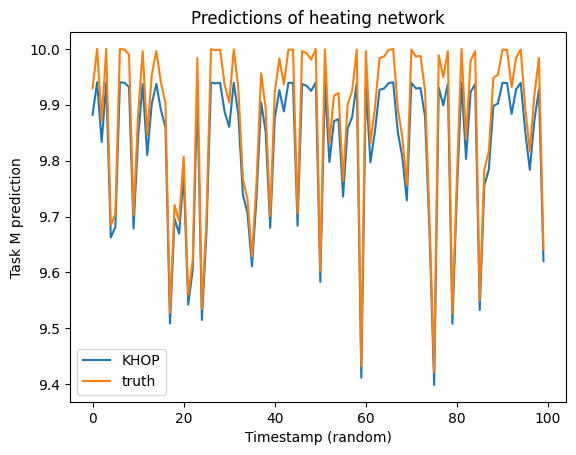

In [ ]:
plot_prediction(test_loader, y_pred, y_truth, 458, config, 100)

### Plot in error in network structure

In [ ]:

s = y_truth.shape
print(f"Shape of y: {s}")
n_graph = int(s[1]/config['N_NODE'])
y_truth = y_truth.reshape(s[0], n_graph, config['N_NODE'], s[-1])
print(y_truth.shape)

y_truth_flat =  torch.flatten(y_truth, start_dim=0, end_dim=1)
y_truth_mean = torch.mean(y_truth_flat, dim=0)
y_truth_final = torch.flatten(y_truth_mean)

s = y_pred.shape
y_pred = y_pred.reshape(s[0], n_graph, config['N_NODE'], s[-1])
y_pred_flat =  torch.flatten(y_pred, start_dim=0, end_dim=1)
y_pred_mean = torch.mean(y_pred_flat, dim=0)
y_pred_final = torch.flatten(y_pred_mean)

errors = y_truth_final - y_pred_final
percentage_errors = errors / ((y_truth_final+1e-15)*100)

print(errors.shape, percentage_errors.shape)




Shape of y: torch.Size([4, 69000, 1])
torch.Size([4, 120, 575, 1])
torch.Size([575]) torch.Size([575])


In [ ]:
unique_point_id = heatingdata.unique_point_id.copy()
normalized_errors = (errors - errors.min()) / (errors.max() - errors.min())

unique_point_id['error'] = errors
unique_point_id['normalized_error'] = normalized_errors
unique_point_id['percentage_error'] = percentage_errors

network_points_supply_plot = network_points_supply.merge(unique_point_id, left_on=network_points_supply['npid'], right_on='id', how='outer').sort_values(by='mappedid').reset_index(drop=True)
errors_dict = {k: v for k, v in zip(network_points_supply_plot['id'], network_points_supply_plot['normalized_error'])}
network_points_supply_plot

,npid,geom,warmth,type,temp,pressure,altitude,X,Y,geometry,id,mappedid,error,normalized_error,percentage_error
0,A.1,0104000020E6100000010000000101000000A1C40A5EC4...,warm,start heating station,85.000000,1000000.00,682.38,7.094499,46.605735,POINT (7.09450 46.60574),A.1,0,0.087729,1.000000,0.000097
1,A.10,0104000020E61000000100000001010000001CC19D76BE...,warm,vanne de purge DN32,84.976300,972542.06,716.90,7.096430,46.605830,POINT (7.09643 46.60583),A.10,1,0.038095,0.732971,0.000042
2,A.100,0104000020E61000000100000001010000000302007456...,warm,elbow 90°,84.627640,923673.00,719.36,7.100916,46.602826,POINT (7.10092 46.60283),A.100,2,0.044249,0.766079,0.000050
3,A.101,0104000020E6100000010000000101000000C1FF56B263...,warm,straight,84.613500,923607.70,719.37,7.100966,46.602797,POINT (7.10097 46.60280),A.101,3,0.045495,0.772785,0.000051
4,A.1011,0104000020E610000001000000010100000060EE2D209A...,warm,straight,84.954530,949061.94,710.00,7.097268,46.604596,POINT (7.09727 46.60460),A.1011,4,0.026506,0.670629,0.000030
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
570,A.98,0104000020E6100000010000000101000000D915300A4D...,warm,T,84.646515,923760.25,719.14,7.100880,46.602864,POINT (7.10088 46.60286),A.98,570,0.041768,0.752735,0.000047
571,A.98.1,0104000020E6100000010000000101000000A35C453F4D...,warm,straight,84.645450,923758.75,719.36,7.100881,46.602865,POINT (7.10088 46.60287),A.98.1,571,0.041541,0.751514,0.000047
572,A.98.2,0104000020E6100000010000000101000000C162C84258...,warm,elbow 90°,84.622570,923727.75,719.35,7.100923,46.602902,POINT (7.10092 46.60290),A.98.2,572,0.042312,0.755659,0.000048
573,A.98.3,0104000020E610000001000000010100000077F9524F51...,warm,HX,84.611490,923712.70,719.34,7.100896,46.602916,POINT (7.10090 46.60292),A.98.3,573,0.042063,0.754320,0.000047


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import networkx as nx
import numpy as np

G = nx.DiGraph()

for i, r in network_points_supply_plot.iterrows():
    G.add_node(r['npid'])

for index, row in pipes_supply.iterrows():
    G.add_edge(row['startpoint'], row['endpoint'], length=row['length'], dn_in=row['dn_in'])

pos = {row['npid']: (float(row['X']), float(row['Y'])) for _, row in network_points_supply.iterrows()}

# Create a color map based on normalized errors
colors = [plt.cm.PiYG(errors_dict[n]) for n in G.nodes()]
# Create a color map based on normalized errors
colormap = cm.PiYG
node_colors = [colormap(errors_dict[n]) for n in G.nodes()]

# Create a ScalarMappable for the color bar
norm = mcolors.Normalize(vmin=errors.min(), vmax=errors.max())
sm = cm.ScalarMappable(cmap=colormap, norm=norm)
sm.set_array([])

# node_colors = []
# for node in G.nodes():
#     if node in supply_nodes_x:
#         node_colors.append('red')
#     else:
#         node_colors.append('black')

H = G.to_undirected()
print(f"Grpah diameter: {nx.diameter(H)}")

plt.figure(figsize=(100, 70))
nodes_size = [400] * len(G.nodes)
nx.draw(G, pos=pos, with_labels=True, font_size=4, node_size=nodes_size, node_color=node_colors)

# Offset for label position
# label_pos = {k: [v[0], v[1] + 40] for k, v in pos.items()}  # Adjust 0.05 as needed

# Draw labels with offset positions
# nx.draw_networkx_labels(G, label_pos)

# Add the color bar
cbar = plt.colorbar(sm, label='Error Value(bar)')
cbar.ax.tick_params(labelsize=40)  # Set tick label font size
cbar.set_label('Error Value(bar)', size=40)  # Set label font size

plt.show()



Grpah diameter: 129


<ipython-input-88-a35c1f530bab>:49: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, label='Error Value(bar)')


# Reload model and training log

In [ ]:
init_model = ct_KHOP(
        num_features=config['N_IN'],
        num_classes=1,
        emb_sizes=emb_sizes,
        device=device,
        max_distance=args.max_distance,
        drpt_prob=args.dropout,
        inside_aggr=inside,
        outside_aggr=outside,
        eps=args.eps,
        batch_norm=args.batch_norm,
        layer_norm=args.layer_norm,
        learnable_emb=args.learnable_emb,
        nb_edge_types=nb_edge_types,
    ).to(device)

# file path of task['M']
# file_path = '/content/drive/My Drive/model/model_state_dict.pth'
# init_model.load_state_dict(torch.load(file_path))
file_path = '/content/drive/MyDrive/MyTensorBoardLogs/runs/Dec11_22-48-06_41b362f9b770'
init_model.load_state_dict(torch.load(file_path))

NameError: ignored

In [ ]:
for _, task in enumerate(config['TASKS']):
    y_idx = to_idx[task]
train_rmse, train_mape, train_mae, y_pred, y_truth = eval(config, init_model, device, test_loader, 'Train', y_idx)

torch.Size([49068, 1])
Train, RMSE_M: 4.0868730545043945, MAPE_M: 644.3203125, MAE_M: 2.2517337799072266
Train, torch_RMSE: 4.0868730545043945


Shape of y: torch.Size([1, 49068, 1])
torch.Size([1, 87, 564, 1])
torch.Size([87]) torch.Size([87])


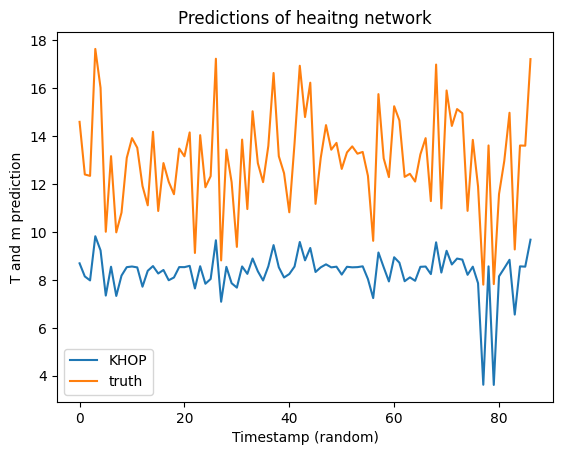

In [ ]:
plot_prediction(test_loader, y_pred, y_truth, 311, config)